In [17]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
from scipy.io import loadmat
import disrnn
import rnn_utils
from rnn_utils import DatasetRNN

# Load Data

In [8]:
matDf = loadmat('..\data\data_for_Meike.mat')['data']
features = matDf.dtype.names
df = pd.DataFrame(np.squeeze(np.array(matDf.tolist())).T, columns=features).drop(columns=['label','Spcorrect1', 'Spcorrect2', 'Snoise']).sort_values(by=['trial'])
df['Reward'] = (df['select'] == 1) * df['Sacc'] + (df['select'] == -1) * df['Pacc']
features = ['dtheta', 'type', 'Pchoice', 'Preport', 'Pacc', 'Schoice', 'Sacc', 'Srt1', 'select', 'Reward'] 
target = ['Sreport']

# Create Train and Testm

In [9]:
batch_size=None
tr = 3
df_test = df[df['block'] >= tr]
df_train = df[df['block'] < tr]

n_trials_train = df_train['trial'].unique().size
n_trials_test = df_test['trial'].unique().size
target_size = df['Sreport'].unique().size
n_sessions = df['subject'].unique().size
features_number = len(features)

xsTrain = np.zeros((n_trials_train, n_sessions, features_number))
ysTrain = np.zeros((n_trials_train, n_sessions, 1))
xsTest = np.zeros((n_trials_test, n_sessions, features_number))
ysTest = np.zeros((n_trials_test, n_sessions, 1))

for i, subject in enumerate(df['subject'].unique()):
    xsTrain[:, i, :] = df_train[df_train['subject'] == subject][features].values
    ysTrain[:, i, :] = df_train[df_train['subject'] == subject][target].values
    xsTest[:, i, :] = df_test[df_test['subject'] == subject][features].values
    ysTest[:, i, :] = df_test[df_test['subject'] == subject][target].values

train = DatasetRNN(xsTrain, ysTrain, batch_size)
test = DatasetRNN(xsTest, ysTest, batch_size)

In [10]:
latent_size = 5
obs_size = xsTrain.shape[-1]
update_mlp_shape = (5, 5, 5)  #@param
choice_mlp_shape = (5, 5, 5)  #@param 
# update_mlp_shape = (3,3,)  #@param
# #@markdown Number of hidden units in each of the two layers of the choice MLP.
# choice_mlp_shape = (2,)
def make_disrnn():
  model = disrnn.HkDisRNN(
      obs_size = obs_size,
      latent_size = latent_size,
      update_mlp_shape = update_mlp_shape,
      choice_mlp_shape = choice_mlp_shape,
      target_size=target_size)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=target_size,
                          eval_mode=True)
  return model

optimizer = optax.adam(learning_rate=1e-2)

Step 2000 of 2000; Loss: 3.9032e+03. (Time: 129.5s)

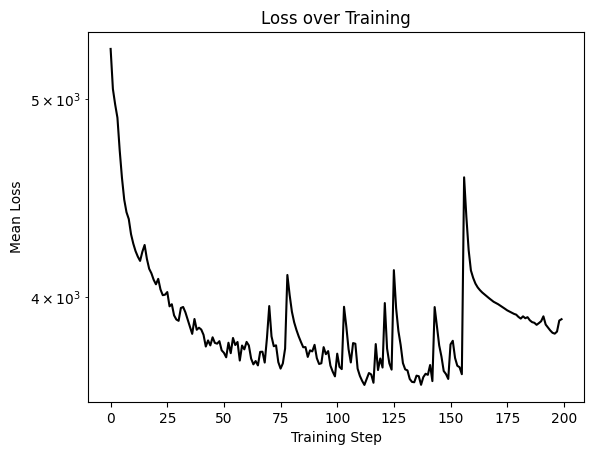

In [11]:
n_steps = 2000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=True,
    truncate_seq_length=200,
)

Step 3000 of 3000; Loss: 3.9542e+03. (Time: 243.0s)

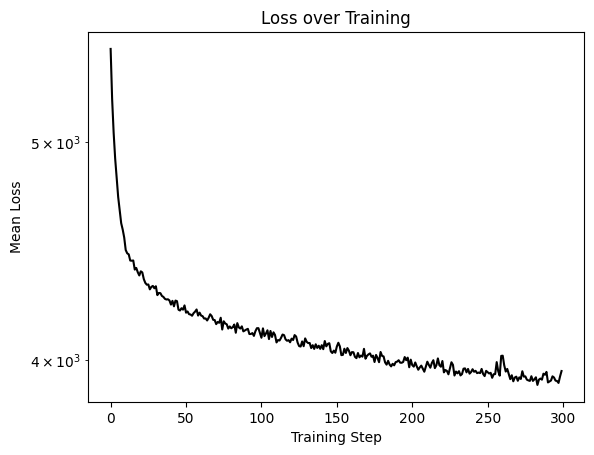

In [12]:
# Now fit more steps with a penalty, to encourage it to find a simple solution
# You can experiment with different values, but colab has been tested with 3000.
n_steps = 3000  #@param
information_penalty = 1e-3  #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=200,
)

(<Figure size 1000x500 with 3 Axes>,
 array([<Axes: title={'center': 'Latent Bottlenecks'}, ylabel='Latent #'>,
        <Axes: title={'center': 'Update MLP Bottlenecks'}, ylabel='Latent #'>],
       dtype=object))

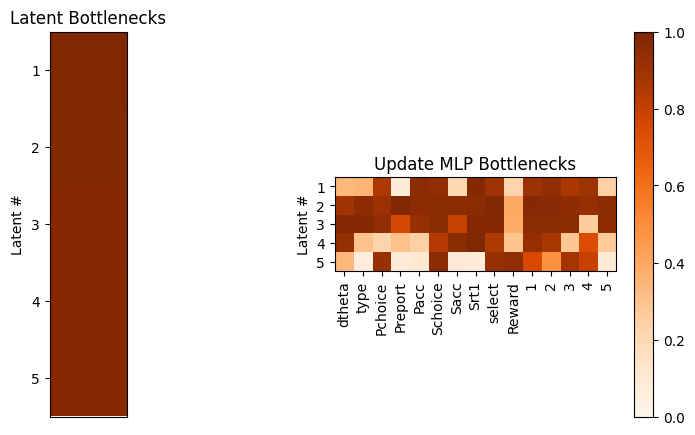

In [16]:
# Visualize bottleneck latents + learned update.
disrnn.plot_bottlenecks(disrnn_params, obs_names=features)
#disrnn.plot_update_rules(disrnn_params, make_disrnn_eval)

Normalized likelihoods

In [19]:
def compute_log_likelihood(dataset, model_fun, params):

  xs, actual_choices = next(dataset)
  n_trials_per_session, n_sessions = actual_choices.shape[:2]
  model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

  predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :-1]))
  # model_outputs[:,:,-1] is full of nans!

  log_likelihood = 0
  n = 0  # Total number of trials across sessions.
  for sess_i in range(n_sessions):
    for trial_i in range(n_trials_per_session):
      actual_choice = int(actual_choices[trial_i, sess_i])-1 # -1 because choices are between 1-6, does not match the indices
      if actual_choice >= 0:  # values < 0 are invalid trials which we ignore.
        log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
        n += 1

  normalized_likelihood = np.exp(log_likelihood / n)

  print(f'Normalized Likelihood: {100 * normalized_likelihood:.1f}%')

  return normalized_likelihood

In [21]:
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood = compute_log_likelihood(
    train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(
    test, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for Disentangled RNN
Training Dataset
Normalized Likelihood: 1.5%
Held-Out Dataset
Normalized Likelihood: 0.8%
